In [40]:
import pandas as pd
#Analisis numerico
import numpy as np
#Visualizacion de datos
import seaborn as sns
import matplotlib.pyplot as plt


# Cargar el archivo de Train

In [41]:
titanic_df = pd.read_csv("train.csv")

## Revisar los primeros registros

In [42]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Revisar los valores nulos del dataset

<AxesSubplot:>

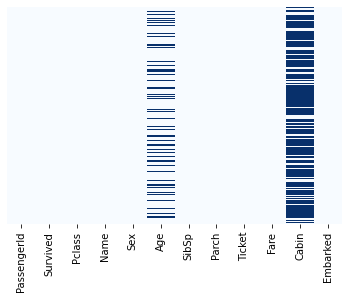

In [44]:
sns.heatmap(titanic_df.isnull(), yticklabels=False, cbar = False, cmap = "Blues")

Se puede ver que las columnas de cabina y edad son los que más datos nulos se tienen, por lo que se debe definir una estrategia para rellenar los campos.

## Edad

In [45]:
titanic_df["Age"].isnull().sum()

177

El conjunto de entrenamiento contiene 177 edades nulas por lo que se calcula el valor promedio de la edad de los demás valores y se rellena en los NA

In [46]:
mean_age = titanic_df["Age"].mean(skipna=True)
titanic_df["Age"] = titanic_df["Age"].fillna(mean_age)
titanic_df["Age"].isnull().sum()

0

## Cabin  

Las cabinas corresponden a las posiciones de las habitaciones, las cabinas más altas son las cabinas de la letra A, y los números identifican la habitación en el piso. por otra parte las cabinas más bajas son la letra F y G.
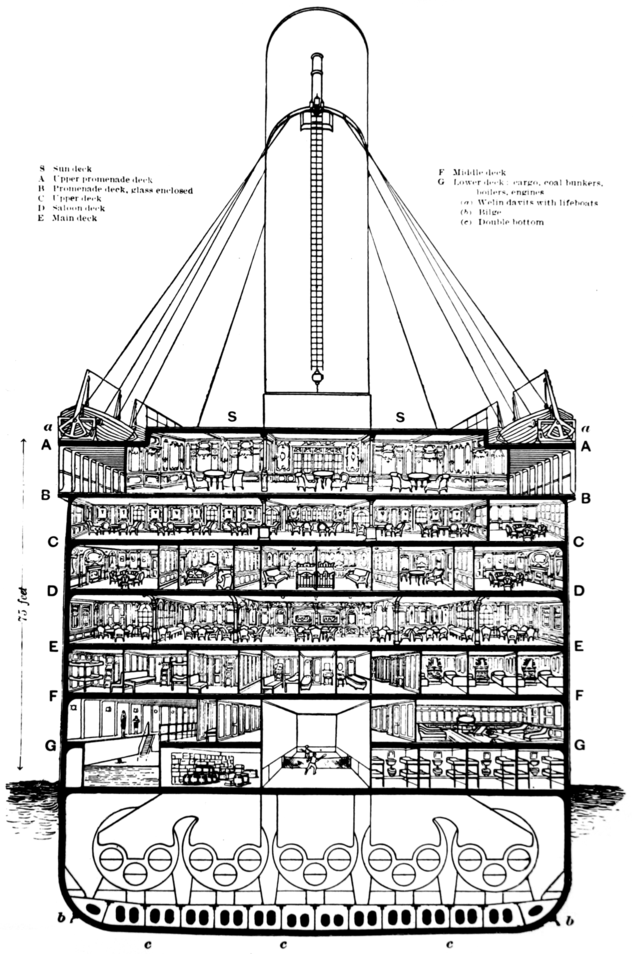

In [47]:
titanic_df["Cabin"].isnull().sum()

687

El conjunto de entrenamiento contiene 687 registros que no tiene datos de la cabina, como la cabina es un valor relacionado a la clase, ya que las cabinas más altas corresponden a las de mayor clase, y las cabinas más bajas las de mejor clase. por lo que se puede rellenar los valores nulos dependiendo de la clase. <br>
PClass 1 -> Cabina B<br>
PClass 2 -> Cabina D<br>
PClass 3 -> Cabina F

In [48]:
titanic_df['Cabin'] = np.where((titanic_df['Pclass'] == 1) & titanic_df['Cabin'].isnull(), "B", titanic_df['Cabin'])
titanic_df['Cabin'] = np.where((titanic_df['Pclass'] == 2) & titanic_df['Cabin'].isnull() , "D", titanic_df['Cabin'])
titanic_df['Cabin'] = np.where((titanic_df['Pclass'] == 3) & titanic_df['Cabin'].isnull(), "F", titanic_df['Cabin'])
titanic_df["Cabin"].isnull().sum()

0

Para la Columna de cabina se puede realizar una transformación, eliminando el número de la cabina y solo dejando la letra, ya que esta es la importante, que es la que significa el nivel del piso en el cuál se encontraba la aplicación.

In [49]:
titanic_df["Cabin"] = titanic_df.Cabin.str[0]

Después de realizar la transformación se tienen los siguientes datos.

In [50]:
titanic_df.groupby("Cabin")["Cabin"].count()

Cabin
A     15
B     87
C     59
D    201
E     32
F    492
G      4
T      1
Name: Cabin, dtype: int64

La cabina T no existe, por lo que se revisa el registro y se realiza el reemplazo necesario

In [51]:
titanic_df[titanic_df["Cabin"] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S


Cómo este registro tiene clase 1, puede que la cabina sea una de las cabinas superiores, por lo que se reemplazará por B

In [52]:
titanic_df['Cabin'] = np.where((titanic_df['Pclass'] == 1) & (titanic_df['Cabin'] == 'T'), "B", titanic_df['Cabin'])
titanic_df[titanic_df["Cabin"] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [53]:
titanic_df.groupby("Cabin")["Cabin"].count()

Cabin
A     15
B     88
C     59
D    201
E     32
F    492
G      4
Name: Cabin, dtype: int64

Como la Columna de cabina es de tipo string y estos valores se deben cambiar a valores numéricos para que lo modelos trabajen, se puede convertir a columnas dummy.

In [54]:
categories = ["Cabin"] 
for category in categories:
  cat_list = "cat" + "_"+category
  cat_dummies = pd.get_dummies(titanic_df[category], prefix=cat_list)
  titanic_df = titanic_df.join(cat_dummies)
data_vars = titanic_df.columns.values.tolist()
to_keep = [v for v in data_vars if v not in categories]
titanic_df = titanic_df[to_keep]
titanic_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'cat_Cabin_A',
       'cat_Cabin_B', 'cat_Cabin_C', 'cat_Cabin_D', 'cat_Cabin_E',
       'cat_Cabin_F', 'cat_Cabin_G'], dtype=object)

## PassengerId - Name - Ticket	 

Estas columnas son columnas que son diferentes para cada registro, por lo que se pueden eliminar, ya que no serviran para entrenar un modelo.

In [56]:
titanic_df = titanic_df.drop("PassengerId", axis=1)
titanic_df = titanic_df.drop("Name", axis=1)
titanic_df = titanic_df.drop("Ticket", axis=1)


In [57]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked     889 non-null    object 
 8   cat_Cabin_A  891 non-null    uint8  
 9   cat_Cabin_B  891 non-null    uint8  
 10  cat_Cabin_C  891 non-null    uint8  
 11  cat_Cabin_D  891 non-null    uint8  
 12  cat_Cabin_E  891 non-null    uint8  
 13  cat_Cabin_F  891 non-null    uint8  
 14  cat_Cabin_G  891 non-null    uint8  
dtypes: float64(2), int64(4), object(2), uint8(7)
memory usage: 61.9+ KB


# Sex

Para la columna se sexo se puede realizar una converción, donde <br>
1 = female <br>
0 = male

In [58]:
#Convertimos la variable female y male, 
# 1 sería mujer
# 0 sería hombre

titanic_df['Sex'] = (titanic_df['Sex']=="female").astype(int)
titanic_df.groupby('Sex').size() 

Sex
0    577
1    314
dtype: int64

# Embarked     

In [59]:
titanic_df.groupby('Embarked').size() 

Embarked
C    168
Q     77
S    644
dtype: int64

Para esta columna se puede realizar la misma idea que con la cabina, convirtiendo los datos en columnas dummy, donde cada columna representa una categogoria de la columna.

In [60]:
categories = ["Embarked"] 
for category in categories:
  cat_list = "cat" + "_"+category
  cat_dummies = pd.get_dummies(titanic_df[category], prefix=cat_list)
  titanic_df = titanic_df.join(cat_dummies)
data_vars = titanic_df.columns.values.tolist()
to_keep = [v for v in data_vars if v not in categories]
titanic_df = titanic_df[to_keep]
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    int64  
 1   Pclass          891 non-null    int64  
 2   Sex             891 non-null    int32  
 3   Age             891 non-null    float64
 4   SibSp           891 non-null    int64  
 5   Parch           891 non-null    int64  
 6   Fare            891 non-null    float64
 7   cat_Cabin_A     891 non-null    uint8  
 8   cat_Cabin_B     891 non-null    uint8  
 9   cat_Cabin_C     891 non-null    uint8  
 10  cat_Cabin_D     891 non-null    uint8  
 11  cat_Cabin_E     891 non-null    uint8  
 12  cat_Cabin_F     891 non-null    uint8  
 13  cat_Cabin_G     891 non-null    uint8  
 14  cat_Embarked_C  891 non-null    uint8  
 15  cat_Embarked_Q  891 non-null    uint8  
 16  cat_Embarked_S  891 non-null    uint8  
dtypes: float64(2), int32(1), int64(4), 

<AxesSubplot:>

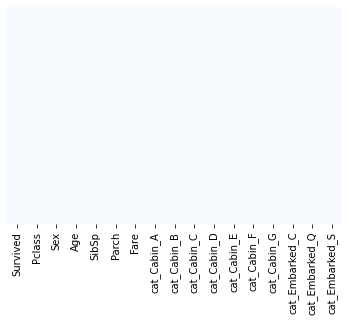

In [61]:
sns.heatmap(titanic_df.isnull(), yticklabels=False, cbar = False, cmap = "Blues")

Después de esta última transformación, todos los tipos de datos ya son numéricos, y no se tienen valores nulos.

# Gráficas Exploratorias

#### Clase Vs Sobrevivió

Text(0, 0.5, 'Sobrevivió')

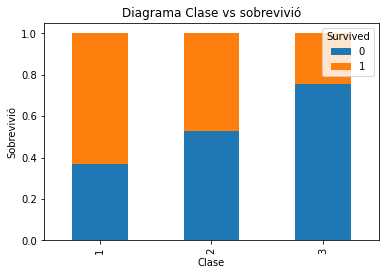

In [75]:
table = pd.crosstab(titanic_df.Pclass, titanic_df.Survived)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama Clase vs sobrevivió")
plt.xlabel("Clase")
plt.ylabel("Sobrevivió")

Se identifica que las personas de clases más altas, son los que más sobrevivieron.

#### Sexo Vs Sobrevivió

Text(0, 0.5, 'Sobrevivió')

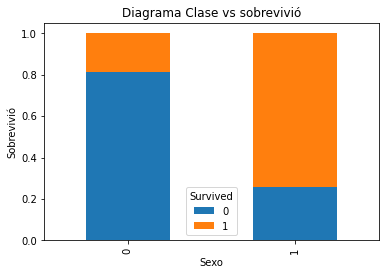

In [76]:
table = pd.crosstab(titanic_df.Sex, titanic_df.Survived)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama Clase vs sobrevivió")
plt.xlabel("Sexo")
plt.ylabel("Sobrevivió")

Se identifica que la mayoria de personas que sobrevivió fueron mujeres

### Edad Vs Sobrevivió

In [69]:
copy_titanic_df = titanic_df.copy()
copy_titanic_df["categoria_edad"] = pd.cut(copy_titanic_df["Age"], bins=[0, 18, 30, copy_titanic_df["Age"].max()], labels=["Joven","Adulto", "Adulto Mayor"])
copy_titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,cat_Cabin_A,cat_Cabin_B,cat_Cabin_C,cat_Cabin_D,cat_Cabin_E,cat_Cabin_F,cat_Cabin_G,cat_Embarked_C,cat_Embarked_Q,cat_Embarked_S,categoria_edad
0,0,3,0,22.000000,1,0,7.2500,0,0,0,0,0,1,0,0,0,1,Adulto
1,1,1,1,38.000000,1,0,71.2833,0,0,1,0,0,0,0,1,0,0,Adulto Mayor
2,1,3,1,26.000000,0,0,7.9250,0,0,0,0,0,1,0,0,0,1,Adulto
3,1,1,1,35.000000,1,0,53.1000,0,0,1,0,0,0,0,0,0,1,Adulto Mayor
4,0,3,0,35.000000,0,0,8.0500,0,0,0,0,0,1,0,0,0,1,Adulto Mayor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.000000,0,0,13.0000,0,0,0,1,0,0,0,0,0,1,Adulto
887,1,1,1,19.000000,0,0,30.0000,0,1,0,0,0,0,0,0,0,1,Adulto
888,0,3,1,29.699118,1,2,23.4500,0,0,0,0,0,1,0,0,0,1,Adulto
889,1,1,0,26.000000,0,0,30.0000,0,0,1,0,0,0,0,1,0,0,Adulto


Text(0, 0.5, 'Sobrevivió')

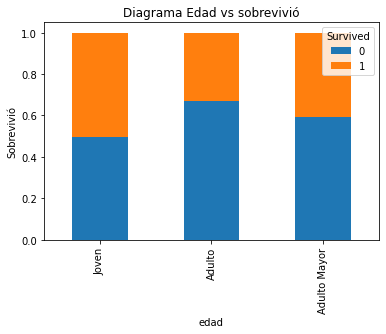

In [74]:
table = pd.crosstab(copy_titanic_df["categoria_edad"], copy_titanic_df.Survived)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama Edad vs sobrevivió")
plt.xlabel("edad")
plt.ylabel("Sobrevivió")

Se agruparon las edades en tres grupos, y se evidencia que los menores de 18 años tuvieron un mayor porcentaje de sobrevivir en cambio los adultos tuvieron el mayor porcentaje de muerte

#### Cabina Vs Sobrevivió

In [87]:
copy_titanic_df["Cabina"] = copy_titanic_df.loc[:, "cat_Cabin_A":"cat_Cabin_G"].idxmax(axis=1).str.replace("cat_Cabin_", "")

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,cat_Cabin_A,cat_Cabin_B,cat_Cabin_C,cat_Cabin_D,cat_Cabin_E,cat_Cabin_F,cat_Cabin_G,cat_Embarked_C,cat_Embarked_Q,cat_Embarked_S,categoria_edad,Cabina
0,0,3,0,22.000000,1,0,7.2500,0,0,0,0,0,1,0,0,0,1,Adulto,F
1,1,1,1,38.000000,1,0,71.2833,0,0,1,0,0,0,0,1,0,0,Adulto Mayor,C
2,1,3,1,26.000000,0,0,7.9250,0,0,0,0,0,1,0,0,0,1,Adulto,F
3,1,1,1,35.000000,1,0,53.1000,0,0,1,0,0,0,0,0,0,1,Adulto Mayor,C
4,0,3,0,35.000000,0,0,8.0500,0,0,0,0,0,1,0,0,0,1,Adulto Mayor,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.000000,0,0,13.0000,0,0,0,1,0,0,0,0,0,1,Adulto,D
887,1,1,1,19.000000,0,0,30.0000,0,1,0,0,0,0,0,0,0,1,Adulto,B
888,0,3,1,29.699118,1,2,23.4500,0,0,0,0,0,1,0,0,0,1,Adulto,F
889,1,1,0,26.000000,0,0,30.0000,0,0,1,0,0,0,0,1,0,0,Adulto,C


Text(0, 0.5, 'Sobrevivió')

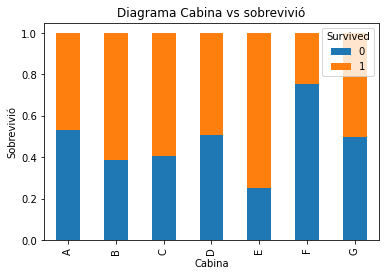

In [94]:
table = pd.crosstab(copy_titanic_df["Cabina"], copy_titanic_df.Survived)

table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama Cabina vs sobrevivió")
plt.xlabel("Cabina")
plt.ylabel("Sobrevivió")

Aunque los de las cabinas altas eran menos personas los porcentajes de personas que sobrevivieron fue alto